# Pylops - MDD with preconditioners

### Author: M.Ravasi

This notebook extends the MDD process in `WaveEquationProcessing_new_and_comparison` by adding some preconditioners, imposing causality and reciprocity:

1. reciprocity: $\mathbf{m} = 0.5 * \mathbf{P2V} (\mathbf{I} + \mathbf{T})  \mathbf{p}$ where $\mathbf{T}$ is a transposition operator such that we enforce that $p(x_R, x_S) = p(x_S, x_R)$ and $\mathbf{P2V}$ is an operator that converts a pressure wavefield into a particle velocity wavefield as required for the model.
2. causuality: $\mathbf{m} = \mathbf{W} \mathbf{p}$ where $\mathbf{W}$ is a window that removes any element at negative time

To better explain the first preconditioner, lets consider the following equation:

$$ g^-_{p, q}(v,s,f) = \int_S g^+_{p, q}(r,s,f) m_{v, q}(r,v,f)  dr$$


here the wavefield to recover is is a monopole (q) to particle velocity (v) wavefield. Therefore we cannot impose reciprocity on this wavefield. However we can consider the monopole to pressure wavefield $p$ and impose reciprocity on this wavefield and subsequently apply a pressure to particle velocity conversion ($P2V()$):

$$ g^-_{p, q}(v,s,f) = \int_S g^+_{p, q}(r,s,f) P2V (p_{p, q}(r,v,f))  dr$$

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

#import warnings
#warnings.filterwarnings('ignore')
import cProfile
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp


from scipy.sparse import csr_matrix, vstack
from scipy.linalg import lstsq, solve
from scipy.sparse.linalg import LinearOperator, cg, lsqr
from scipy import misc

from pylops.utils                      import dottest
from pylops.utils.wavelets             import *
from pylops.utils.seismicevents        import *
from pylops.utils.tapers               import *
from pylops.basicoperators             import *
from pylops.signalprocessing           import *
from pylops.waveeqprocessing.mdd       import *
from pylops.waveeqprocessing.wavedecomposition import *
from pylops.optimization.leastsquares  import *

In [3]:
###### Input parameters
par = {'ox':-400,  'dx':10,    'nx':81,
       'oy':-400,  'dy':10,    'ny':81,
       'ot':0,     'dt':0.004, 'nt':400,
       'f0': 20,   'nfmax': 200}

t0_m    = [0.2]
vrms_m  = [1100.]
amp_m   = [1.]

t0_G    = [0.2,0.5,0.7]
vrms_G  = [1200.,1500., 2000.]
amp_G   = [1.,0.6,0.5]

# Create taper for operator
#tap = taper3d(par['nt'], [par['ny'], par['nx']], [5,5], tapertype='hanning')

# Create axis
t,t2,x,y = makeaxis(par)

# Create wavelet
wav = ricker(t[:41], f0=par['f0'])[0]

# Generate model
m, mwav = np.zeros((par['nx'], par['nx'], par['nt'])), np.zeros((par['nx'],par['nx'],par['nt']))
for ix,x0 in enumerate(x):
    m[ix],mwav[ix] = hyperbolic2d(x-x0,t,t0_m,vrms_m,amp_m,wav)

# Convert model to particle velocity
nfftf = 2 ** 9
nfftk = 2 ** 8
PtoVop = PressureToVelocity(par['nt'], par['nx'],
                            par['dt'], par['dx'],
                            1000, 2000,
                            nffts=(nfftk, nfftf),
                            critical=100.,
                            ntaper=11,
                            topressure=False)           
for ix,x0 in enumerate(x):
    m[:, ix] = (PtoVop * m[:, ix].ravel()).reshape(par['nx'], par['nt'])
    mwav[:, ix] = (PtoVop * mwav[:, ix].ravel()).reshape(par['nx'], par['nt'])

# Generate operator
G, Gwav = np.zeros((par['ny'], par['nx'], par['nt'])), np.zeros((par['ny'],par['nx'],par['nt']))
for iy,y0 in enumerate(y):
    G[iy], Gwav[iy] = hyperbolic2d(x-y0,t,t0_G,vrms_G,amp_G,wav)
#G,Gwav = G*tap, Gwav*tap

# Add negative part to data and model
m     = np.concatenate((np.zeros((par['nx'], par['nx'], par['nt']-1)),    m), axis=-1)
mwav  = np.concatenate((np.zeros((par['nx'], par['nx'], par['nt']-1)), mwav), axis=-1)
Gwav2 = np.concatenate((np.zeros((par['ny'], par['nx'], par['nt']-1)), Gwav), axis=-1)

Gwav_fft = np.fft.rfft(Gwav2, 2*par['nt']-1, axis=-1)
Gwav_fft = Gwav_fft[...,:par['nfmax']]

MDCop=MDC(Gwav_fft.transpose(2,0,1), nt=2*par['nt']-1,
          nv=par['nx'], dt=par['dt'], dr=par['dx'], 
          twosided=True)
dottest(MDCop, (2*par['nt']-1)*par['nx']*par['ny'],(2*par['nt']-1)*par['nx']*par['nx'], verb=True)

# Create data
d = MDCop * m.transpose(2,0,1).flatten()
d = d.reshape(2*par['nt']-1, par['ny'], par['nx'])

/var/folders/pc/wf4mhn4n2cv8wjt_jtj8t8qhsljrkk/T/ipykernel_51165/2515477687.py:40: ComplexWarning: Casting complex values to real discards the imaginary part
  m[:, ix] = (PtoVop * m[:, ix].ravel()).reshape(par['nx'], par['nt'])
/var/folders/pc/wf4mhn4n2cv8wjt_jtj8t8qhsljrkk/T/ipykernel_51165/2515477687.py:41: ComplexWarning: Casting complex values to real discards the imaginary part
  mwav[:, ix] = (PtoVop * mwav[:, ix].ravel()).reshape(par['nx'], par['nt'])


Dot test passed, v^H(Opu)=36889.67797625813 - u^H(Op^Hv)=36889.677976258565


In [4]:
# MDD
madj = MDCop.H * d.flatten()
minv, istop, itn, r1norm, r2norm = lsqr(MDCop, d.flatten(), damp=1e-10, iter_lim=10, show=1)[0:5]

madj = madj.reshape(2*par['nt']-1, par['nx'], par['nx'])
minv = minv.reshape(2*par['nt']-1, par['nx'], par['nx'])

 
LSQR            Least-squares solution of  Ax = b
The matrix A has 5242239 rows and 5242239 columns
damp = 1.00000000000000e-10   calc_var =        0
atol = 1.00e-06                 conlim = 1.00e+08
btol = 1.00e-06               iter_lim =       10
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   8.085e-04  8.085e-04    1.0e+00  1.9e+05
     1  2.78470e-11   4.543e-04  4.543e-04    5.6e-01  6.8e-01   1.8e+02  1.0e+00
     2  4.31675e-11   3.055e-04  3.055e-04    3.8e-01  3.9e-01   2.6e+02  2.2e+00
     3  5.92018e-11   2.328e-04  2.328e-04    2.9e-01  2.9e-01   3.2e+02  3.6e+00
     4  4.52870e-11   1.865e-04  1.865e-04    2.3e-01  2.2e-01   3.7e+02  5.2e+00
     5  3.59458e-11   1.538e-04  1.538e-04    1.9e-01  1.8e-01   4.2e+02  7.0e+00
     6 -1.56969e-11   1.307e-04  1.307e-04    1.6e-01  1.6e-01   4.5e+02  8.9e+00
     7 -1.20799e-10   1.126e-04  1.126e-04    1.4e-01  1.4e-01   4.9e+02  1.1e+01
     8 -2.03310e-10   9.773e

In [5]:
# MDD with reciprocity preconditioning
nfftf = 2 ** 10
nfftk = 2 ** 8
PtoVop = PressureToVelocity(2*par['nt']-1, par['nx'],
                            par['dt'], par['dx'],
                            1000, 2000,
                            nffts=(nfftk, nfftf),
                            critical=100.,
                            ntaper=11,
                            topressure=False)           
PtoVop = BlockDiag([PtoVop]*par['nx'])
Top = Transpose((2*par['nt']-1, par['nx'], par['nx']), (1, 2, 0))

Recop =  0.5 * (Identity((2*par['nt']-1) * par['nx'] * par['nx']) + \
                Transpose((2*par['nt']-1, par['nx'], par['nx']), (0, 2, 1)))
PtoVop = Top.H * PtoVop * Top 
MDCop_prec = MDCop * PtoVop * Recop

In [6]:
pinvprec, istop, itn, r1norm, r2norm = lsqr(MDCop_prec, d.flatten(), damp=1e-10, iter_lim=10, show=1)[0:5]

# inverted velocity field
minvprec = np.real((PtoVop * Recop * pinvprec).reshape(2*par['nt']-1, par['nx'], par['nx']))

# preconditioned pressure field (symmetric)
pinvprecrec = np.real((Recop * pinvprec).reshape(2*par['nt']-1, par['nx'], par['nx']))

# inverted pressure field
pinvprec = np.real(pinvprec.reshape(2*par['nt']-1, par['nx'], par['nx']))

 
LSQR            Least-squares solution of  Ax = b
The matrix A has 5242239 rows and 5242239 columns
damp = 1.00000000000000e-10   calc_var =        0
atol = 1.00e-06                 conlim = 1.00e+08
btol = 1.00e-06               iter_lim =       10
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   8.085e-04  8.085e-04    1.0e+00  8.3e-02


/opt/anaconda3/envs/pylops/lib/python3.9/site-packages/scipy/sparse/linalg/_isolve/lsqr.py:562: ComplexWarning: Casting complex values to real discards the imaginary part
  str1 = '%6g %12.5e' % (itn, x[0])


     1  3.65780e-05   5.294e-04  5.294e-04    6.5e-01  6.0e-01   8.8e-05  1.0e+00
     2  7.35758e-05   3.950e-04  3.950e-04    4.9e-01  3.6e-01   1.3e-04  2.3e+00
     3  1.03328e-04   3.189e-04  3.189e-04    3.9e-01  2.5e-01   1.6e-04  3.8e+00
     4  6.16661e-05   2.700e-04  2.700e-04    3.3e-01  1.9e-01   1.8e-04  5.5e+00
     5  8.76026e-05   2.365e-04  2.365e-04    2.9e-01  1.6e-01   2.1e-04  7.3e+00
     6  1.48199e-04   2.118e-04  2.118e-04    2.6e-01  1.3e-01   2.2e-04  9.3e+00
     7  1.12836e-04   1.929e-04  1.929e-04    2.4e-01  1.0e-01   2.4e-04  1.1e+01
     8 -6.96931e-05   1.774e-04  1.774e-04    2.2e-01  9.6e-02   2.6e-04  1.4e+01
     9 -2.60367e-04   1.650e-04  1.650e-04    2.0e-01  8.2e-02   2.7e-04  1.6e+01
    10 -1.30366e-04   1.549e-04  1.549e-04    1.9e-01  7.6e-02   2.8e-04  1.9e+01
 
LSQR finished
The iteration limit has been reached                      
 
istop =       7   r1norm = 1.5e-04   anorm = 2.8e-04   arnorm = 3.3e-09
itn   =      10   r2norm = 1.5e

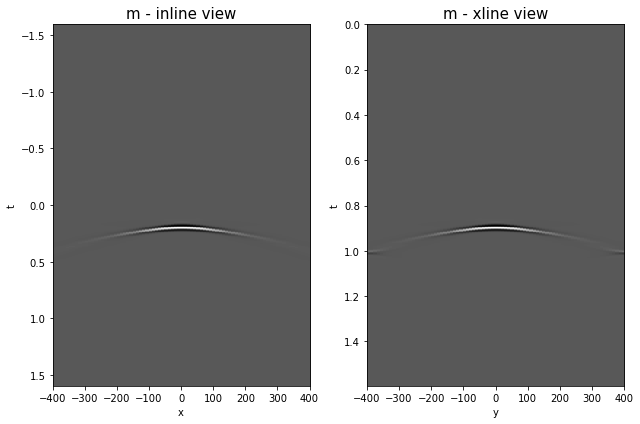

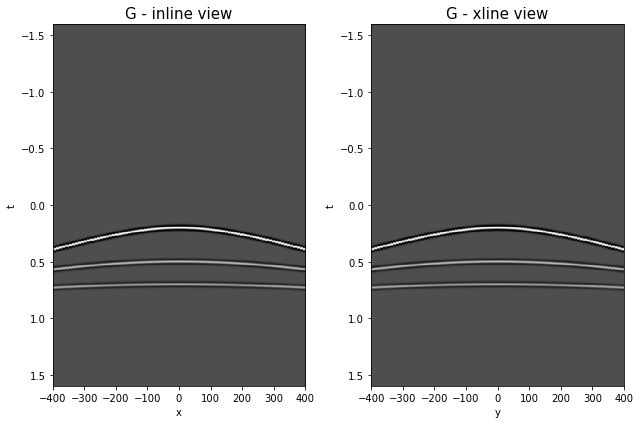

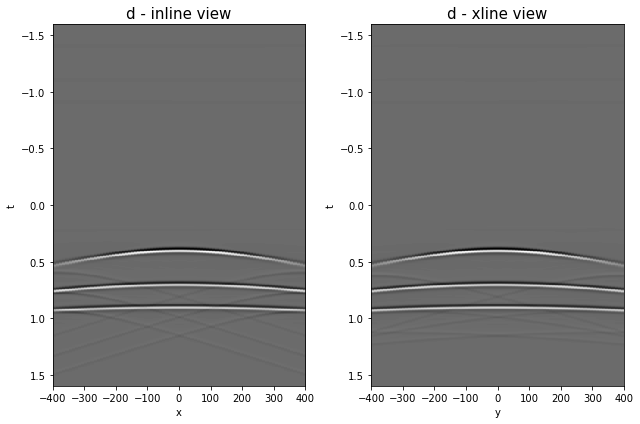

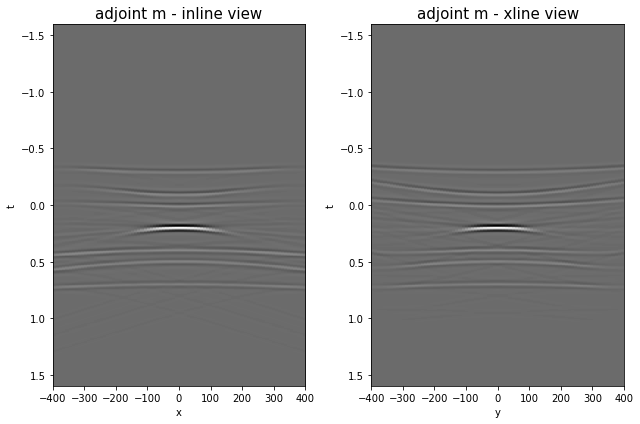

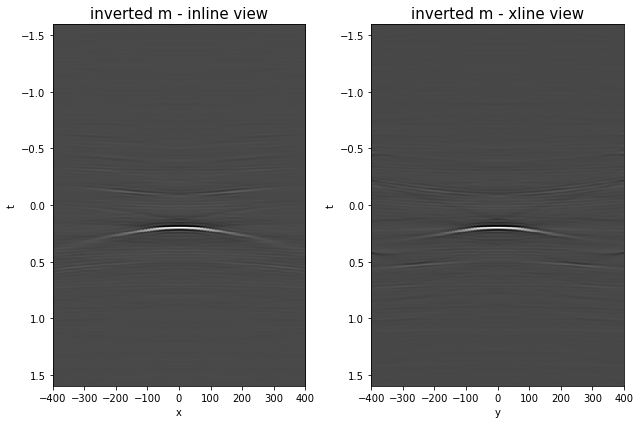

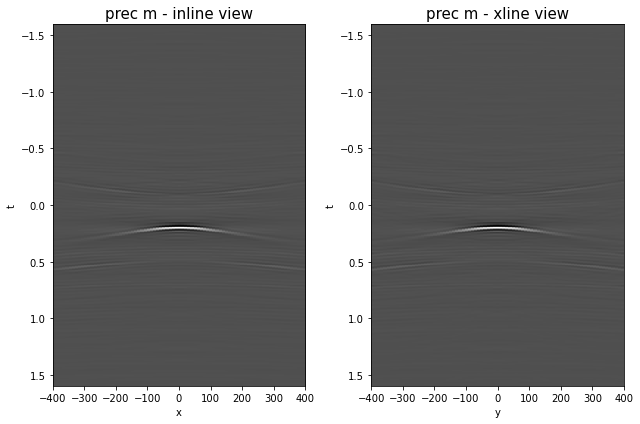

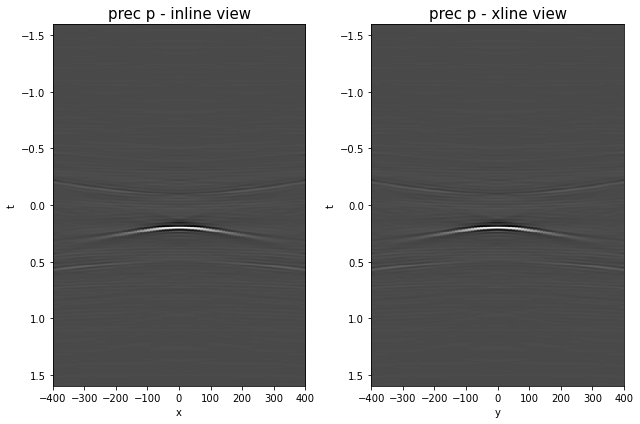

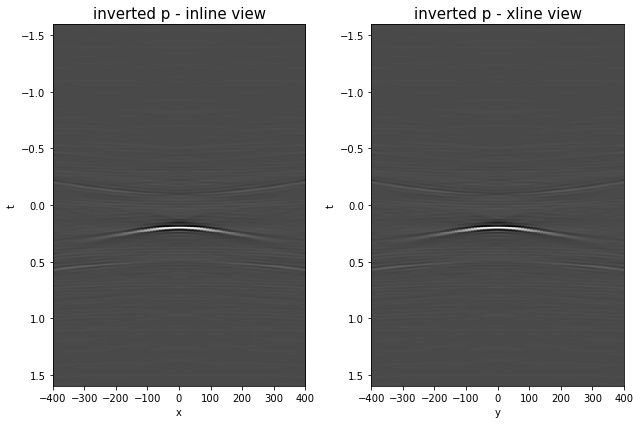

In [7]:
# Plotting
plt.figure(figsize=(9,6))
plt.subplot(121)
plt.imshow(mwav[int(par['nx']/2)].T,aspect='auto',
           interpolation='nearest', cmap='gray',
           extent=(x.min(),x.max(),t2.max(),t2.min()))
plt.title('m - inline view', fontsize=15)
plt.xlabel('x'),plt.ylabel('t')
plt.subplot(122)
plt.imshow(mwav[:, int(par['nx']/2), :].T,aspect='auto',
           interpolation='nearest', cmap='gray',
           extent=(y.min(),y.max(),t2.max(),t.min()))
plt.title('m - xline view', fontsize=15)
plt.xlabel('y'),plt.ylabel('t')
plt.tight_layout()

plt.figure(figsize=(9,6))
plt.subplot(121)
plt.imshow(Gwav2[int(par['ny']/2)].T,aspect='auto',
           interpolation='nearest', cmap='gray',
           extent=(x.min(),x.max(),t2.max(),t2.min()))
plt.title('G - inline view', fontsize=15)
plt.xlabel('x'),plt.ylabel('t')
plt.subplot(122)
plt.imshow(Gwav2[:,int(par['nx']/2)].T,aspect='auto',
           interpolation='nearest', cmap='gray',
           extent=(y.min(),y.max(),t2.max(),t2.min()))
plt.title('G - xline view', fontsize=15)
plt.xlabel('y'),plt.ylabel('t')
plt.tight_layout()


plt.figure(figsize=(9,6))
plt.subplot(121)
plt.imshow(d[:, int(par['ny']/2)],aspect='auto',
           interpolation='nearest', cmap='gray',
           extent=(x.min(),x.max(),t2.max(),t2.min()))
plt.title('d - inline view', fontsize=15)
plt.xlabel('x'),plt.ylabel('t')
plt.subplot(122)
plt.imshow(d[:, :,int(par['nx']/2)],aspect='auto',
           interpolation='nearest', cmap='gray',
           extent=(y.min(),y.max(),t2.max(),t2.min()))
plt.title('d - xline view', fontsize=15)
plt.xlabel('y'),plt.ylabel('t')
plt.tight_layout()


plt.figure(figsize=(9,6))
plt.subplot(121)
plt.imshow(madj[:, int(par['nx']/2)],aspect='auto',
           interpolation='nearest', cmap='gray',
           extent=(x.min(),x.max(),t2.max(),t2.min()))
plt.title('adjoint m - inline view', fontsize=15)
plt.xlabel('x'),plt.ylabel('t')
plt.subplot(122)
plt.imshow(madj[:, :, int(par['nx']/2)],aspect='auto',
           interpolation='nearest', cmap='gray',
           extent=(y.min(),y.max(),t2.max(),t2.min()))
plt.title('adjoint m - xline view', fontsize=15)
plt.xlabel('y'),plt.ylabel('t')
plt.tight_layout()


plt.figure(figsize=(9,6))
plt.subplot(121)
plt.imshow(minv[:, int(par['nx']/2)],aspect='auto',
           interpolation='nearest', cmap='gray',
           extent=(x.min(),x.max(),t2.max(),t2.min()))
plt.title('inverted m - inline view', fontsize=15)
plt.xlabel('x'),plt.ylabel('t')
plt.subplot(122)
plt.imshow(minv[:, :, int(par['nx']/2)],aspect='auto',
           interpolation='nearest', cmap='gray',
           extent=(y.min(),y.max(),t2.max(),t2.min()))
plt.title('inverted m - xline view', fontsize=15)
plt.xlabel('y'),plt.ylabel('t')
plt.tight_layout()


plt.figure(figsize=(9,6))
plt.subplot(121)
plt.imshow(minvprec[:, int(par['nx']/2)],aspect='auto',
           interpolation='nearest', cmap='gray',
           extent=(x.min(),x.max(),t2.max(),t2.min()))
plt.title('prec m - inline view', fontsize=15)
plt.xlabel('x'),plt.ylabel('t')
plt.subplot(122)
plt.imshow(minvprec[:, :, int(par['nx']/2)],aspect='auto',
           interpolation='nearest', cmap='gray',
           extent=(y.min(),y.max(),t2.max(),t2.min()))
plt.title('prec m - xline view', fontsize=15)
plt.xlabel('y'),plt.ylabel('t')
plt.tight_layout()


plt.figure(figsize=(9,6))
plt.subplot(121)
plt.imshow(pinvprecrec[:, int(par['nx']/2)],aspect='auto',
           interpolation='nearest', cmap='gray',
           extent=(x.min(),x.max(),t2.max(),t2.min()))
plt.title('prec p - inline view', fontsize=15)
plt.xlabel('x'),plt.ylabel('t')
plt.subplot(122)
plt.imshow(pinvprecrec[:, :, int(par['nx']/2)],aspect='auto',
           interpolation='nearest', cmap='gray',
           extent=(y.min(),y.max(),t2.max(),t2.min()))
plt.title('prec p - xline view', fontsize=15)
plt.xlabel('y'),plt.ylabel('t')
plt.tight_layout()


plt.figure(figsize=(9,6))
plt.subplot(121)
plt.imshow(pinvprec[:, int(par['nx']/2)], aspect='auto',
           interpolation='nearest', cmap='gray',
           extent=(x.min(),x.max(),t2.max(),t2.min()))
plt.title('inverted p - inline view', fontsize=15)
plt.xlabel('x'),plt.ylabel('t')
plt.tight_layout()
plt.subplot(122)
plt.imshow(pinvprec[:, :, int(par['nx']/2)], aspect='auto',
           interpolation='nearest', cmap='gray',
           extent=(y.min(),y.max(),t2.max(),t2.min()))
plt.title('inverted p - xline view', fontsize=15)
plt.xlabel('y'),plt.ylabel('t')
plt.tight_layout()

Finally we check if the reciprocity has been satisfied

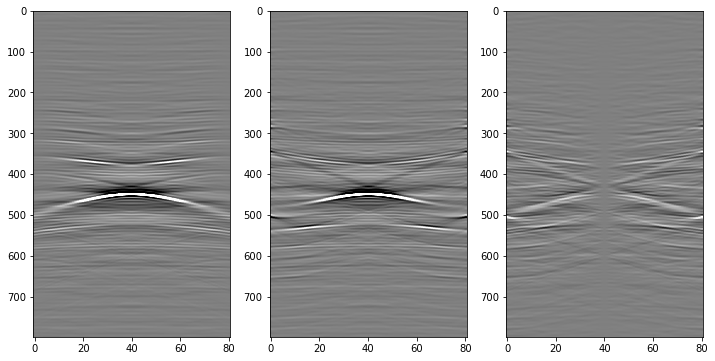

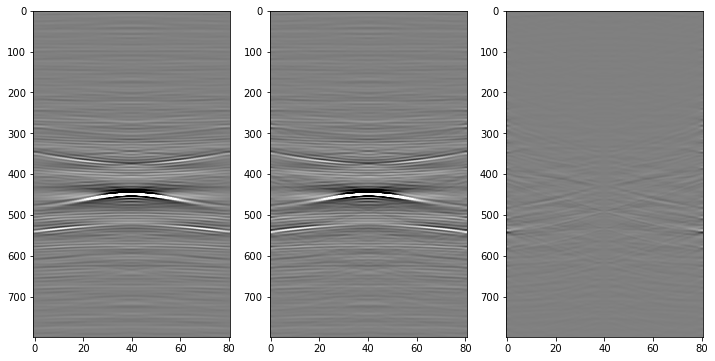

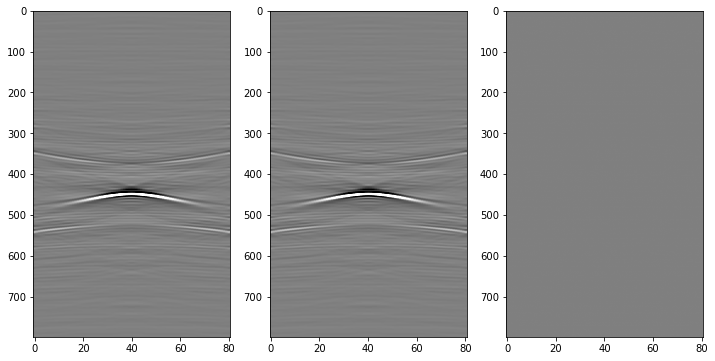

In [8]:
ivs = par['nx'] // 2

fig, axs = plt.subplots(1, 3, figsize=(12, 6))
axs[0].imshow(minv[:, ivs], vmin=-1e-8, vmax=1e-8, cmap='gray')
axs[0].axis('tight')
axs[1].imshow(minv[:, :, ivs], vmin=-1e-8, vmax=1e-8, cmap='gray')
axs[1].axis('tight')
axs[2].imshow(minv[:, ivs] - minv[:, :, ivs], vmin=-1e-8, vmax=1e-8, cmap='gray')
axs[2].axis('tight')

fig, axs = plt.subplots(1, 3, figsize=(12, 6))
axs[0].imshow(minvprec[:, ivs], vmin=-1e-8, vmax=1e-8, cmap='gray')
axs[0].axis('tight')
axs[1].imshow(minvprec[:, :, ivs], vmin=-1e-8, vmax=1e-8, cmap='gray')
axs[1].axis('tight')
axs[2].imshow(minvprec[:, ivs] - minvprec[:, :, ivs], vmin=-1e-8, vmax=1e-8, cmap='gray')
axs[2].axis('tight');

fig, axs = plt.subplots(1, 3, figsize=(12, 6))
axs[0].imshow(pinvprecrec[:, ivs], vmin=-5e-2, vmax=5e-2, cmap='gray')
axs[0].axis('tight')
axs[1].imshow(pinvprecrec[:, :, ivs], vmin=-5e-2, vmax=5e-2, cmap='gray')
axs[1].axis('tight')
axs[2].imshow(pinvprecrec[:, ivs] - pinvprecrec[:, :, ivs], vmin=-5e-2, vmax=5e-2, cmap='gray')
axs[2].axis('tight');

In [9]:
pinvprecrec[:, 40] - pinvprecrec[:, :, 40]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])